In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
#choose kernel (keras-env) when run on Macbook Pro 
import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import torch
from datetime import datetime
import calendar
import random
import speasy as spz
from speasy import amda 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import toml
plt.style.use('custom_style.mplstyle')

In [2]:
def E_mhd(df):
    '''
    [B] = nT
    [u] = km/s
    [E] = µV/m => mV/m
    '''
    dg = pd.DataFrame(index=df.index,columns=['ex','ey','ez'])
    dg['ex']=(df['by']*df['uz']-df['uy']*df['bz'])/1e3
    dg['ey']=-(df['bz']*df['ux']-df['uz']*df['bx'])/1e3 #MINUS SIGN TO FIT MEASUREMENTS IN MMS1 MAYBE THERE IS A ISSUE WITH THE MEASUREMENT TOOL IN MMS1
    dg['ez']=(df['bx']*df['uy']-df['ux']*df['by'])/1e3
    return dg

def E_hall(df):
    '''
    [B] = nT
    [j] = A/m^2
    [n] = cm^-3
    [E] = *1e-15 V/m => 1e-12 mV/m
    '''
    dg = pd.DataFrame(index=df.index,columns=['ex','ey','ez'])
    dg['ex']= ((df['jy']*df['bz']-df['by']*df['jz'])/(e*df['e_density']))/1e12
    dg['ey']= ((df['jz']*df['bx']-df['bz']*df['jx'])/(e*df['e_density']))/1e12
    dg['ez']= ((df['jx']*df['by']-df['bx']*df['jy'])/(e*df['e_density']))/1e12
    return dg

In [3]:
config = toml.load('model_config.toml')
seed = config['stat']['seed']
t1 = config['data']['t1']
t2 = config['data']['t2']
sat = config['data']['sat']
density_threshold = config['data']['density_threshold']
name = config['model']['name']
f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
shuffle = config['model']['shuffle']
PINNS = config['model']['PINNS']

In [4]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed)
# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
# 4. Set the `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed)
torch.use_deterministic_algorithms(mode=False)

In [5]:
e = 1.602176634e-19
m_i = 1.67262192369e-27
m_e = 9.1093837015e-31
## Global interval - all the data will be inside this range
store = pd.HDFStore('./data.hdf5','r')
bursts = store.keys()
store.close()
del store

bursts = [datetime.strptime(burst, '/mms1_%Y_%m_%dT%H_%M_%S') for burst in bursts]
bursts = pd.DataFrame(bursts)
bursts = bursts.where((str(t1.date()) < bursts)&(bursts < str(t2.date()))).dropna()
df = pd.concat([pd.read_hdf('./data.hdf5',key=sat+"_"+datetime.strftime(pd.to_datetime(event[0]),format='%Y_%m_%dT%H_%M_%S')) for event in bursts.values]).dropna()
df['ux']=(m_i*df['vx_i']+m_e*df['vx_e'])/(m_i+m_e)
df['uy']=(m_i*df['vy_i']+m_e*df['vy_e'])/(m_i+m_e)
df['uz']=(m_i*df['vz_i']+m_e*df['vz_e'])/(m_i+m_e)
df = df.where(df['e_density']>density_threshold).dropna()

In [6]:
if PINNS:
    df[['ex_mhd','ey_mhd','ez_mhd']] = E_mhd(df)
    df[['ex_hall','ey_hall','ez_hall']] = E_hall(df)
    ## Input / Output wanted
    input_features = ['bx', 'by', 'bz',
                'jx', 'jy', 'jz',
                'ux', 'uy', 'uz',
                'ex_mhd','ey_mhd','ez_mhd',
                'ex_hall','ey_hall','ez_hall',
                'e_density',]
    output_targets = ['ex','ey','ez']
else:
    ## Input / Output wanted
    input_features = ['bx', 'by', 'bz',
                'jx', 'jy', 'jz',
                'ux', 'uy', 'uz',
                'e_density',]
    output_targets = ['ex','ey','ez']

df = df.drop(df.columns.drop(input_features+output_targets),axis=1)
df = df[input_features + output_targets] #reorder columns for input to the left and output to the right
df0 = df

In [7]:
## Train interval 
id_train_beg = 0
id_train_end = int(len(df.index)*(f_train))

t_train_begin = df.index.values[0]
t_train_end = df.index.values[id_train_end]
print("Train interval: ", t_train_begin, t_train_end)

## Validation interval

id_val_beg = id_train_end+1
id_val_end = int(len(df.index)*(f_train+f_valid))
t_val_begin = df.index.values[id_val_beg]
t_val_end = df.index.values[id_val_end]
print("Validation interval: ", t_val_begin, t_val_end)

## Test interval 
id_test_beg = id_val_end + 1
id_test_end =  int(len(df.index))-1
t_test_begin = df.index.values[id_test_beg]
t_test_end = df.index.values[id_test_end]
print("Test interval: ", t_test_begin, t_test_end)


df_train, df_test = train_test_split(df,test_size = f_test+f_valid,train_size=f_train,random_state=seed,shuffle=shuffle)
df_val, df_test = train_test_split(df_test,test_size= f_test/(f_test+f_valid), random_state=seed, shuffle=shuffle)
#df_val, df_test = df_test.iloc[:len(df_test)//2,:], df_test.iloc[len(df_test)//2:,:]

Train interval:  2015-09-07T13:12:32.321000000 2015-10-24T08:23:23.606000000
Validation interval:  2015-10-24T08:23:23.756000000 2015-11-01T03:33:06.639000000
Test interval:  2015-11-01T03:33:06.789000000 2015-11-06T13:52:57.343000000


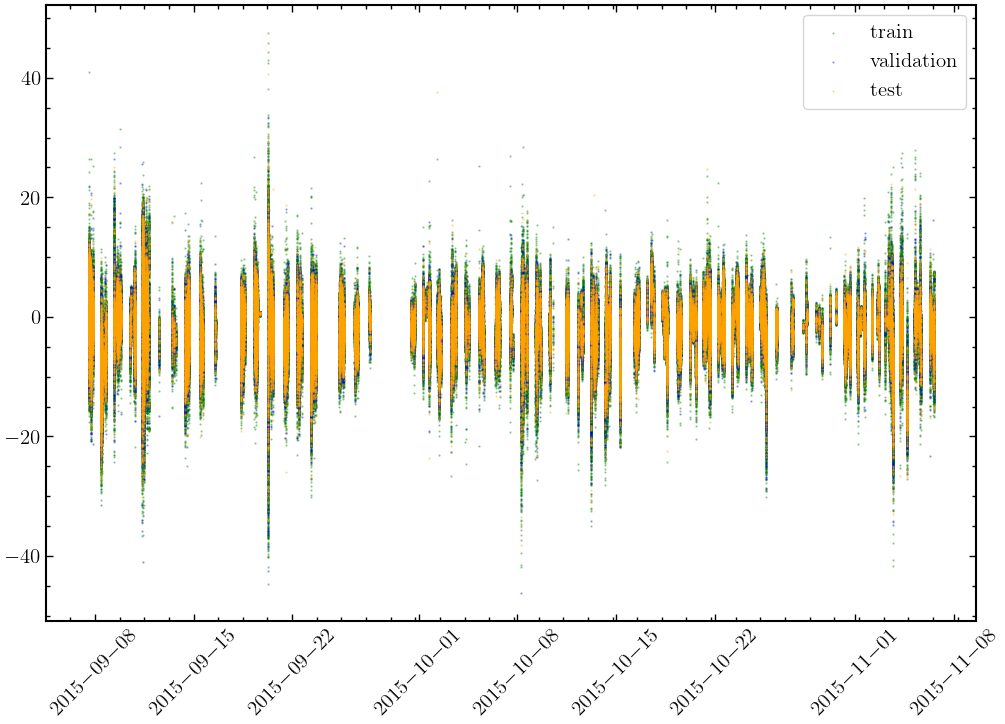

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(df_train.index,df_train['ex'],s=0.5, rasterized=True, color='green', label='train',alpha=0.33)
ax.scatter(df_val.index,df_val['ex'],s=0.5, rasterized=True, color='blue', label='validation',alpha=0.33)
ax.scatter(df_test.index,df_test['ex'],s=0.5, rasterized=True, color='orange', label='test',alpha=0.33)
plt.xticks(rotation=45)
plt.legend()

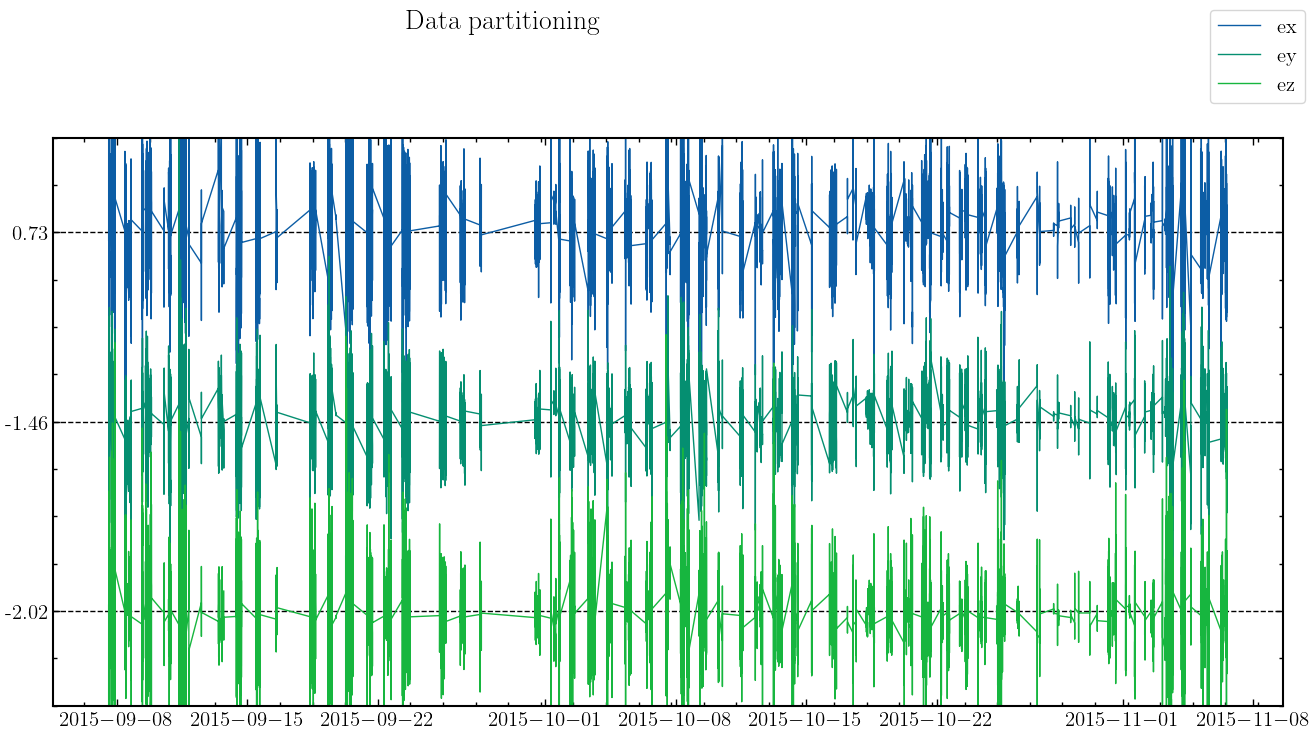

In [9]:
def f(X,mid):
    Y = mid + (X - X.mean()) / (X.max() - X.min())
    return Y
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.25)

#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_train_beg],xmax=df.index[id_train_end],label='train',color='green',alpha=0.5)
#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_val_beg],xmax=df.index[id_val_end],label='validation',color='blue',alpha=0.5)
#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_test_beg],xmax=df.index[id_test_end],label='test',color='orange',alpha=0.5)

mids = 1*(np.linspace(0,1,4)[1:]+np.linspace(0,1,4)[:-1])/2

ax.axhline(mids[0],color='black',linestyle='--')
ax.axhline(mids[1],color='black',linestyle='--')
ax.axhline(mids[2],color='black',linestyle='--')
ax.plot(df.index.values,1*f(df['ex'],mids[-1]),label='ex')
ax.plot(df.index.values,1*f(df['ey'],mids[-2]),label='ey')
ax.plot(df.index.values,1*f(df['ez'],mids[-3]),label='ez')

ax.set_yticks(mids,[f'{df[e].mean():.2f}' for e in ['ex','ey','ez']])
ax.set_ylim(0,1)
fig.legend()

fig.subplots_adjust(top=0.82)
fig.subplots_adjust(right=1.15)
fig.suptitle("Data partitioning", fontsize=20)

plt.show()

In [10]:
## Define a scaler function
scaler = MinMaxScaler()
## Obtain scaler based on the “train” data
df_train_scaled = scaler.fit_transform(df_train)
## Apply the scaling obtained from the “train” data to “validation” and “test” data
df_val_scaled = scaler.transform(df_val)
df_test_scaled = scaler.transform(df_test)

In [11]:
## Get input 'X'
X_train = df_train_scaled[:,0:len(input_features)]
X_test = df_test_scaled[:,0:len(input_features)]
X_val = df_val_scaled[:,0:len(input_features)]
## Get output 'y'
y_train = df_train_scaled[:,len(input_features):len(input_features)+len(output_targets)]
y_test = df_test_scaled[:,len(input_features):len(input_features)+len(output_targets)]
y_val = df_val_scaled[:,len(input_features):len(input_features)+len(output_targets)]

In [12]:
# Recreate the exact same model, including its weights and the optimizer
model = keras.models.load_model(f'../Saved_models/{name}/model.keras')

# Show the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 16)               │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 64)               │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,147 (66.98 KB)

 Trainable params: 5,715 (22.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,432 (44.66 KB)

In [13]:
test_predict = model.predict(X_test)

3994/3994 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


In [14]:
print('Test 1', t_test_begin, t_test_end)

score_test = model.evaluate(X_test, y_test, verbose=0)
print('\nLoss score = ', score_test)

mse_test = []
for i in range(y_test.shape[1]):
    mse_test.append(mean_squared_error(y_test[:,i], test_predict[:,i]))
print('\nMSE of all targets = ', mse_test)

Pcc_xyz_test = []
for i in range(y_test.shape[1]):
    Pcc_xyz_test.append(round(np.corrcoef(y_test[:,i], test_predict[:,i])[0,1],3))
print('\nPcc of all targets = ', Pcc_xyz_test)

r2_xyz_test = []
for i in range(y_test.shape[1]):
    r2_xyz_test.append(round(r2_score(y_test[:,i], test_predict[:,i]),3))
print('\nr2 of all targets = ', r2_xyz_test)


Test 1 2015-11-01T03:33:06.789000000 2015-11-06T13:52:57.343000000

Loss score =  0.0077511160634458065

MSE of all targets =  [0.0001482131918372127, 9.026316365527995e-05, 0.0001883816709585413]

Pcc of all targets =  [0.978, 0.974, 0.919]

r2 of all targets =  [0.946, 0.945, 0.827]


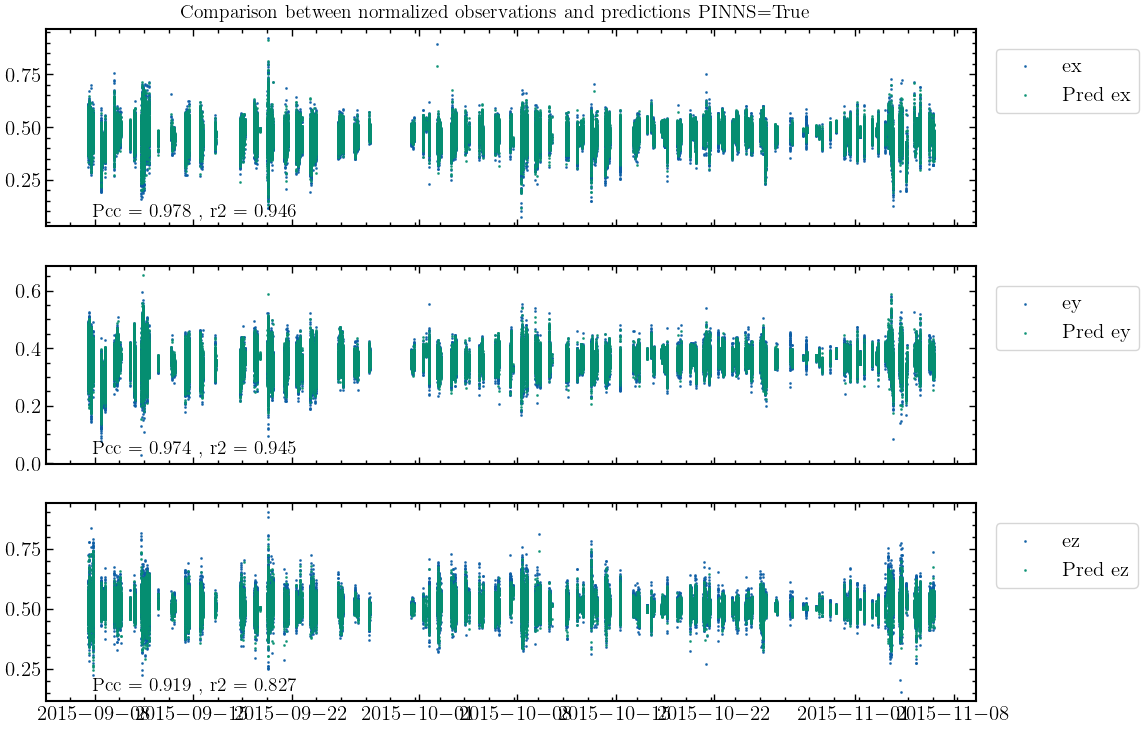

In [19]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8),facecolor='white')
plt.subplots_adjust(hspace=0.2)
#plt.style.use('ggplot')

target_labels = output_targets

for i in range(y_test.shape[1]):
    ax[i].scatter(df_test.index,y_test[:,i],s=1, rasterized=True, label=target_labels[i],alpha=0.8)
    ax[i].scatter(df_test.index,test_predict[:,i],s=1, rasterized=True, label='Pred {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_theo_scale[test_ind_begin:test_ind_end,i], label='Theo {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_mhd_scale[test_ind_begin:test_ind_end,i], label='MHD {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_hall_scale[test_ind_begin:test_ind_end,i], label='Hall {}'.format(target_labels[i]),alpha=0.8)
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
    text = str('Pcc = {}'.format(Pcc_xyz_test[i])) + str(' , r2 = {}'.format(r2_xyz_test[i]))
    ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
    
for i in range(y_test.shape[1]-1):
    plt.setp(ax[i].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle(f"Comparison between normalized observations and predictions PINNS={PINNS}", fontsize=14)

plt.show()

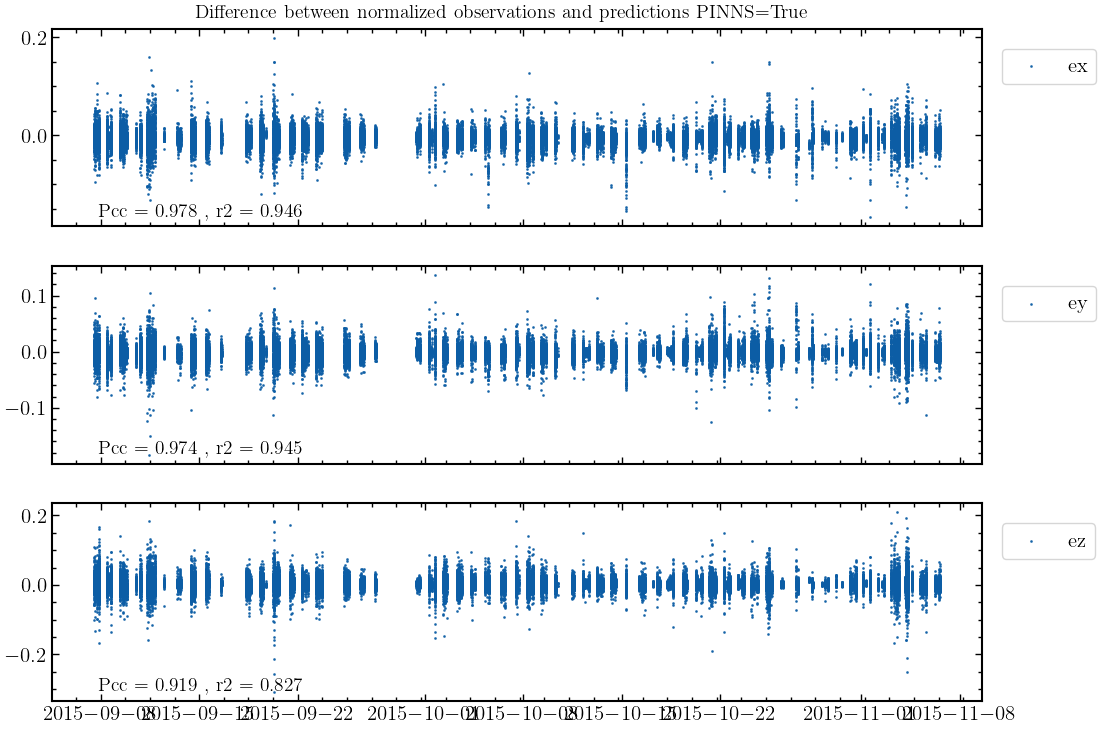

In [20]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8),facecolor='white')
plt.subplots_adjust(hspace=0.2)
#plt.style.use('ggplot')

target_labels = output_targets

for i in range(y_test.shape[1]):
    ax[i].scatter(df_test.index, y_test[:,i]-test_predict[:,i],s=1,rasterized=True, label=target_labels[i],alpha=0.8)
    #ax[i].plot(d_theo_scale[test_ind_begin:test_ind_end,i], label='Theo {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_mhd_scale[test_ind_begin:test_ind_end,i], label='MHD {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_hall_scale[test_ind_begin:test_ind_end,i], label='Hall {}'.format(target_labels[i]),alpha=0.8)
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
    text = str('Pcc = {}'.format(Pcc_xyz_test[i])) + str(' , r2 = {}'.format(r2_xyz_test[i]))
    ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
    
for i in range(y_test.shape[1]-1):
    plt.setp(ax[i].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle(f"Difference between normalized observations and predictions PINNS={PINNS}", fontsize=14)

plt.show()

In [21]:
# test
predict_scaled = np.concatenate((X_test[:,:],test_predict), axis=1)
print(predict_scaled.shape)
print(predict_scaled)

(127801, 19)
[[0.58027646 0.4187483  0.56360398 ... 0.48652747 0.34777951 0.49490055]
 [0.67020484 0.47821475 0.63899476 ... 0.44011733 0.39391369 0.52383137]
 [0.63002615 0.34175456 0.67358338 ... 0.45476586 0.31468618 0.4735235 ]
 ...
 [0.65148457 0.43634423 0.72887284 ... 0.4784157  0.37275544 0.50551873]
 [0.59763728 0.4546901  0.74035491 ... 0.43527982 0.3192144  0.51259911]
 [0.67846562 0.23572066 0.38429334 ... 0.5557906  0.41580325 0.47231537]]


In [22]:
# test 
predict = scaler.inverse_transform(predict_scaled)
print(predict)
print(predict.shape)

[[  2.93730492  -3.48681321  12.901954   ...   0.17419932  -2.48947076
   -0.71174721]
 [ 17.38313253   8.55651589  30.87062394 ...  -4.10606971   2.41903288
    1.54367241]
 [ 10.9289475  -19.07982485  39.11449212 ...  -2.75507978  -6.01047771
   -2.37828293]
 ...
 [ 14.37596402   0.07676838  52.29220352 ...  -0.57392547   0.16787437
    0.11603636]
 [  5.72609448   3.79223078  55.02884541 ...  -4.55221909  -5.52869156
    0.66801598]
 [ 18.71011945 -40.55414079 -29.83501886 ...   6.56213116   4.74800103
   -2.47246737]]
(127801, 19)


In [23]:
# test 
df_predict = pd.DataFrame(predict)
df_predict.columns = df0.columns
df_predict['time'] = df_test.index
df_predict = df_predict.set_index(['time'])
df_predict

,bx,by,bz,jx,jy,jz,ux,uy,uz,ex_mhd,ey_mhd,ez_mhd,ex_hall,ey_hall,ez_hall,e_density,ex,ey,ez
time,,,,,,,,,,,,,,,,,,,
2015-10-21 09:02:17.680,2.937305,-3.486813,12.901954,6.744565e-09,-8.226694e-08,1.664674e-07,-229.090450,12.877299,-22.310942,-0.088348,2.890180,-0.760971,-0.070103,0.058586,0.031793,42.821935,0.174199,-2.489471,-0.711747
2015-09-21 12:27:47.142,17.383133,8.556516,30.870624,4.398849e-09,-2.972719e-10,4.321244e-09,85.350286,151.087770,-16.557588,-4.805849,-2.922639,1.896078,-0.274496,-0.360896,0.254598,1.049403,-4.106070,2.419033,1.543672
2015-10-25 11:28:33.077,10.928947,-19.079825,39.114492,1.229364e-07,2.742541e-07,4.304903e-07,-165.406530,96.414289,52.467516,-4.772267,7.043207,-2.102221,2.214481,-0.012134,-0.624665,53.385139,-2.755080,-6.010478,-2.378283
2015-10-21 08:04:00.106,6.820858,-5.292104,-4.145058,1.987246e-08,6.207831e-09,7.897040e-08,-345.439771,30.113792,-5.774125,0.155381,-1.471252,-1.622701,0.079574,0.126004,-0.029930,30.761744,0.036603,1.620507,-1.758101
2015-10-22 13:27:34.653,22.667020,-38.226272,-27.404182,9.703636e-08,-5.697008e-08,1.050621e-10,-78.721735,129.160412,-84.011843,6.750995,-4.061603,-0.081557,0.774801,1.317501,-1.196923,12.608948,7.088770,4.837394,-1.274677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-26 09:29:44.377,-0.218362,-4.735401,14.294749,3.602934e-08,-3.944161e-08,-2.553832e-08,-25.363745,48.133688,0.311998,-0.689536,0.362500,-0.130618,-0.306922,-0.228352,-0.080334,13.924795,-0.418449,-0.414970,-0.306258
2015-10-31 12:16:13.645,4.242565,-1.934366,12.613355,-1.647658e-08,3.884943e-08,9.594909e-08,-55.205242,82.349498,-13.858853,-1.011895,0.637526,0.242586,0.149867,0.136396,-0.029491,28.137720,-0.475197,-0.401136,0.050573
2015-11-02 04:20:21.488,14.375964,0.076768,52.292204,-2.950279e-08,2.568342e-08,1.051624e-07,14.184622,25.512020,87.963815,-1.327327,0.522819,0.365671,0.362269,0.828917,-0.100811,23.000083,-0.573925,0.167874,0.116036


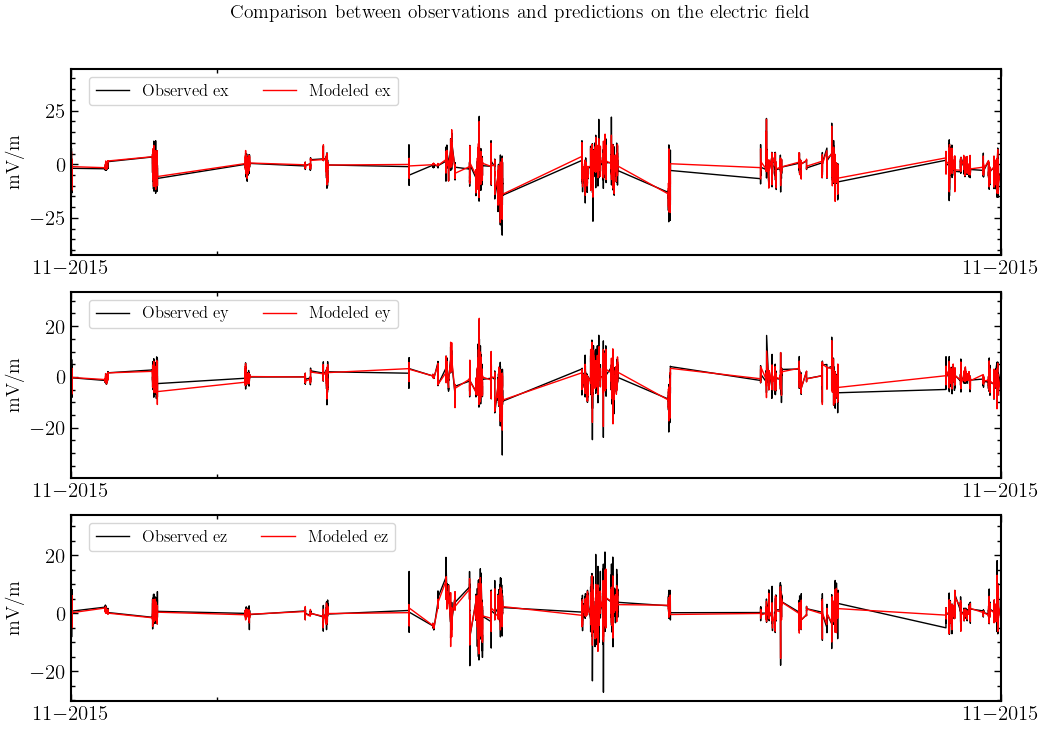

In [26]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        ax[j].plot(df_test.sort_index()[col], label='Observed ' + col, color='k')
        ax[j].plot(df_predict.sort_index()[col], label='Modeled ' + col, color='r')
        #ax[j].plot(d_mhd[col+'_mhd'], label='MHD ' + col, color='g')
        #ax[j].plot(d_hall[col+'_hall'], label='Hall ' + col, color='b')
        ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
        ax[j].set_xlim(t_test_begin, t_test_end)
        ax[j].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax[j].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        ax[j].set_ylabel('mV/m', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        #text = str('Pcc = {}'.format(Pcc_xyz[j])) + str(' , r$^2$ = {}'.format(r2_xyz[j]))
        #ax[j].text(0.75, 0.05, text, fontsize=14, transform=ax[j].transAxes)

#ax[0].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[0]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[0]].max() + 10)
#ax[1].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[1]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[1]].max() + 10)
#ax[2].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[2]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[2]].max() + 10)
    
fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison between observations and predictions on the electric field", fontsize=14)

plt.show()

In [ ]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        ax[j].plot(df_test[col]-df_predict[col], label='Diff ' + col, color='k')
        #ax[j].plot(d_mhd[col+'_mhd'], label='MHD ' + col, color='g')
        #ax[j].plot(d_hall[col+'_hall'], label='Hall ' + col, color='b')
        ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
        ax[j].set_xlim(t_test_begin, t_test_end)
        ax[j].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax[j].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        ax[j].set_ylabel('mV/m', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        #text = str('Pcc = {}'.format(Pcc_xyz[j])) + str(' , r$^2$ = {}'.format(r2_xyz[j]))
        #ax[j].text(0.75, 0.05, text, fontsize=14, transform=ax[j].transAxes)

#ax[0].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[0]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[0]].max() + 10)
#ax[1].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[1]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[1]].max() + 10)
#ax[2].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[2]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[2]].max() + 10)
    
fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison between observations and predictions on the electric field", fontsize=14)

plt.show()

In [ ]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        sns.histplot(df_test[col],ax=ax[j],stat='density',color='blue',alpha=0.8)
        sns.histplot(df_predict[col],ax=ax[j],stat='density',color='red',alpha=0.8)

plt.tight_layout()
plt.show()

In [27]:
1/6

0.16666666666666666